In [153]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [154]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples = n_samples, noise = 0.03, random_state= 42)

In [155]:
print(f"First 5 X values:\n{X[:5]}\nFirst 5 y values:\n{y[:5]}")

First 5 X values:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y values:
[1 1 1 1 0]


In [156]:
import pandas as pd
df = pd.DataFrame({"X1": X[:, 0],
                   "X2": X[:, 1],
                  "label": y
                  })

In [157]:
df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


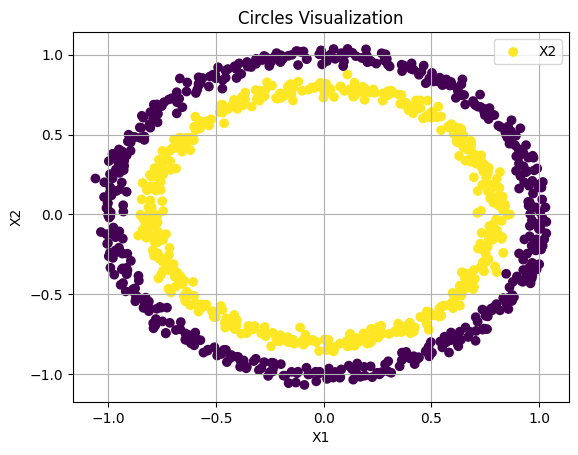

In [158]:
def plot_predictions():
    plt.scatter(data = df, x ="X1", y = "X2", c = 'label')
    plt.title("Circles Visualization")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid()
    plt.legend()

plot_predictions()

In [159]:
X.shape, y.shape

((1000, 2), (1000,))

In [160]:
X_tensor = torch.tensor(X, dtype = torch.float32)
y_tensor = torch.tensor(y, dtype = torch.float32)

X_tensor.shape, y_tensor.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [161]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size= 0.2, random_state= 42)

In [162]:
X_train.shape

torch.Size([800, 2])

In [163]:
# Lets build a model

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [164]:
from torch import nn

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features= 2, out_features= 5) # takes 2 featues and upsacles to 5 features
        self.layer_2 = nn.Linear(in_features= 5, out_features= 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        # x -> layer_1 -> layer_2
        return self.layer_2(self.layer_1(x))

In [165]:
model_0 = CircleModelV0().to(device)

In [166]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [167]:
model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features= 5, out_features= 1)
).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [168]:
with torch.inference_mode():
  untrained_preds = model_1(X_test.to(device))
print(untrained_preds[:10].squeeze())
print(y_test[:10])

tensor([-0.4181, -0.4132, -0.5494, -0.3803, -0.7379, -0.7335, -0.5705, -0.6460,
        -0.5413, -0.4150], device='cuda:0')
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [169]:
## setting up a loss function
# loss_fn =nn.BCELoss() - This funciton assumes that the inputs are processed with sigmoid

loss_fn = nn.BCEWithLogitsLoss()
# this is equivalent to but its better in efficency

#loss_fn = nn.Sequential(
#    nn.Sigmoid(),
#    nn.BCELoss()
#)

optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [170]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct/len(y_true)) * 100

In [171]:
epoch_count = []
train_loss_val = []
test_loss_val = []
acc = []

epochs = 500

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):

  model_1.train()

  y_preds = model_1.forward(X_train).squeeze()

  loss = loss_fn(y_preds, y_train)

  accuracy = accuracy_fn(y_true = y_train, y_pred = y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    y_train_preds = model_1.forward(X_test)

    loss_test = loss_fn(y_train_preds.squeeze(), y_test)

  if epoch % 10 == 0:
    print(f"Epoch = {epoch} | accuracy = {accuracy} | train_loss = {loss} | test_loss = {loss_test}")
    epoch_count.append(epoch)
    acc.append(accuracy)
    train_loss_val.append(loss)
    test_loss_val.append(loss_test)

Epoch = 0 | accuracy = 0.0 | train_loss = 0.735015869140625 | test_loss = 0.7323002219200134
Epoch = 10 | accuracy = 0.0 | train_loss = 0.7095201015472412 | test_loss = 0.7090392708778381
Epoch = 20 | accuracy = 0.0 | train_loss = 0.6999589204788208 | test_loss = 0.7002094388008118
Epoch = 30 | accuracy = 0.0 | train_loss = 0.6962818503379822 | test_loss = 0.6967850923538208
Epoch = 40 | accuracy = 0.0 | train_loss = 0.6947968602180481 | test_loss = 0.6954145431518555
Epoch = 50 | accuracy = 0.0 | train_loss = 0.6941392421722412 | test_loss = 0.6948398351669312
Epoch = 60 | accuracy = 0.0 | train_loss = 0.6938046813011169 | test_loss = 0.6945851445198059
Epoch = 70 | accuracy = 0.0 | train_loss = 0.6936057209968567 | test_loss = 0.6944671273231506
Epoch = 80 | accuracy = 0.0 | train_loss = 0.69347083568573 | test_loss = 0.6944122314453125
Epoch = 90 | accuracy = 0.0 | train_loss = 0.6933712363243103 | test_loss = 0.6943893432617188
Epoch = 100 | accuracy = 0.0 | train_loss = 0.69329422

In [174]:
def plot_loss():
  plt.scatter(epoch_count, np.array(torch.tensor(train_loss_val).cpu().numpy()), label = 'Train', c="green")
  plt.scatter(epoch_count, np.array(torch.tensor(test_loss_val).cpu().numpy()), label = 'Test', c="orange")
  # plt.scatter(epoch_count, np.array(torch.tensor(acc).cpu().numpy()), label = 'Accuracy', c="lime")
  plt.title("Loss over time")
  plt.xlabel("Epoch")
  plt.ylabel("Loss Value")
  plt.grid()
  plt.legend()

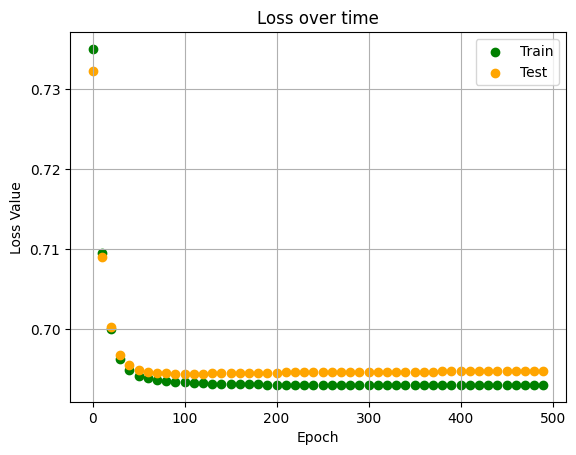

In [175]:
plot_loss()

In [178]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print('helper_funciton already exits! skipping')
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_funciton already exits! skipping


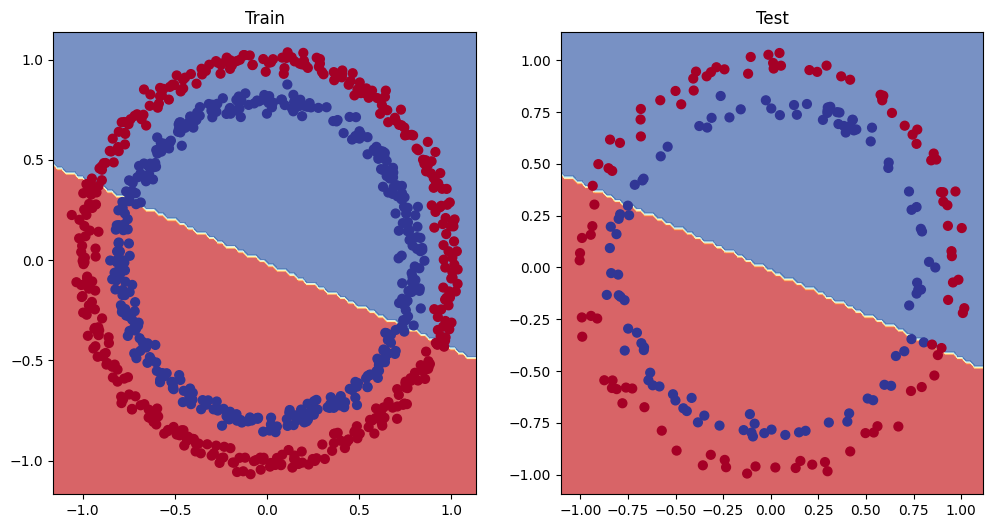

In [180]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


In [185]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features= 2, out_features= 10)
    self.layer2 = nn.Linear(in_features= 10, out_features= 10)
    self.layer3 = nn.Linear(in_features= 10, out_features= 1)

  def forward(self, x:torch.tensor) -> torch.tensor:
    return self.layer3(self.layer2(self.layer1(x)))

In [190]:
model_2 = CircleModelV1().to(device)
model_2

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [191]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

In [192]:
epochs = 100

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_2.train()

  y_pred = model_2.forward(X_train).squeeze()

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()

  with  torch.inference_mode():
    y_test_preds = model_2.forward(X_test).squeeze()

    loss_test = loss_fn(y_test_preds, y_test)

    if epoch % 10 == 0:
      print(f"Epoch = {epoch} | accuracy = {accuracy} | train_loss = {loss} | test_loss = {loss_test}")


Epoch = 0 | accuracy = 0.0 | train_loss = 0.6935356259346008 | test_loss = 0.6938309073448181
Epoch = 10 | accuracy = 0.0 | train_loss = 0.693293571472168 | test_loss = 0.693630039691925
Epoch = 20 | accuracy = 0.0 | train_loss = 0.6931940317153931 | test_loss = 0.6935595273971558
Epoch = 30 | accuracy = 0.0 | train_loss = 0.6931496262550354 | test_loss = 0.6935396194458008
Epoch = 40 | accuracy = 0.0 | train_loss = 0.6931269764900208 | test_loss = 0.6935394406318665
Epoch = 50 | accuracy = 0.0 | train_loss = 0.6931130886077881 | test_loss = 0.6935468912124634
Epoch = 60 | accuracy = 0.0 | train_loss = 0.693103015422821 | test_loss = 0.6935575604438782
Epoch = 70 | accuracy = 0.0 | train_loss = 0.6930949091911316 | test_loss = 0.6935696005821228
Epoch = 80 | accuracy = 0.0 | train_loss = 0.6930879354476929 | test_loss = 0.69358229637146
Epoch = 90 | accuracy = 0.0 | train_loss = 0.693081796169281 | test_loss = 0.6935952305793762
